<a href="https://colab.research.google.com/github/JeremyKrick/ComposerNet/blob/jeremy_dev/ComposerNet_jeremy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries

In [ ]:
!pip install mido soundfile pretty_midi librosa
#!sudo apt install -y fluidsynth
#!pip install --upgrade pyfluidsynth

# Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from mido import MidiFile
import pretty_midi
import librosa
import librosa.display
import seaborn as sns
import soundfile as sf
import os
import pandas as pd

# Mounting Google Drive to Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load files to dataframe

In [5]:
def create_dataframe_from_files(root_directory):
    file_data = []

    for root, _, files in os.walk(root_directory):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            subfolder_name = os.path.relpath(root, root_directory)
            file_data.append({
                'File_Path': file_path,
                'Subfolder_Name': subfolder_name,
                'File_Name': file_name
            })

    df = pd.DataFrame(file_data)
    return df

root_directory_path = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/train'
df = create_dataframe_from_files(root_directory_path)

print(df)

                                             File_Path Subfolder_Name  \
0    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
1    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
2    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
3    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
4    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
..                                                 ...            ...   
285  /content/drive/MyDrive/AAI 511/Composer_Datase...         hummel   
286  /content/drive/MyDrive/AAI 511/Composer_Datase...           bach   
287  /content/drive/MyDrive/AAI 511/Composer_Datase...           bach   
288  /content/drive/MyDrive/AAI 511/Composer_Datase...           bach   
289  /content/drive/MyDrive/AAI 511/Composer_Datase...           bach   

         File_Name  
0    mozart002.mid  
1    mozart008.mid  
2    mozart036.mid  
3    mozart042.mid  
4    mozart030.mid

In [6]:
df

,File_Path,Subfolder_Name,File_Name
0,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart002.mid
1,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart008.mid
2,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart036.mid
3,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart042.mid
4,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart030.mid
...,...,...,...
285,/content/drive/MyDrive/AAI 511/Composer_Datase...,hummel,hummel300.mid
286,/content/drive/MyDrive/AAI 511/Composer_Datase...,bach,bach362.mid
287,/content/drive/MyDrive/AAI 511/Composer_Datase...,bach,bach363.mid
288,/content/drive/MyDrive/AAI 511/Composer_Datase...,bach,bach377.mid


# Synthesize MIDI file to np.array

In [ ]:
# Load MIDI file into PrettyMIDI object
midi_data = pretty_midi.PrettyMIDI(df.iloc[0,0])
# Print an empirical estimate of its global tempo
print(midi_data.estimate_tempo())
# Compute the relative amount of each semitone across the entire song,
# a proxy for key
total_velocity = sum(sum(midi_data.get_chroma()))
print([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])
# Shift all notes up by 5 semitones
for instrument in midi_data.instruments:
    # Don't want to shift drum notes
    if not instrument.is_drum:
        for note in instrument.notes:
            note.pitch += 5
# Synthesize the resulting MIDI data using sine waves
audio_data = midi_data.synthesize()

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


234.97935567128462
[0.01140707542123846, 0.07466232665731268, 0.20466635337211955, 0.007106745818508571, 0.1349633131695364, 0.010839810967419877, 0.11396604646581741, 0.08143030781810773, 0.03685961286943024, 0.242262503344323, 0.002356655497109167, 0.07947924859907689]


# Convert MIDI data to spectrogram

In [ ]:
# Write audio data to .wav format
sf.write('/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/stereo_file1.wav', audio_data, 48000, 'PCM_24')

In [ ]:
# https://www.kaggle.com/code/msripooja/steps-to-convert-audio-clip-to-spectrogram
# Load .wav file
y, sr = librosa.load('/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/stereo_file1.wav')

In [ ]:
print(type(y), type(sr))
print(y.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(10897865,) 22050


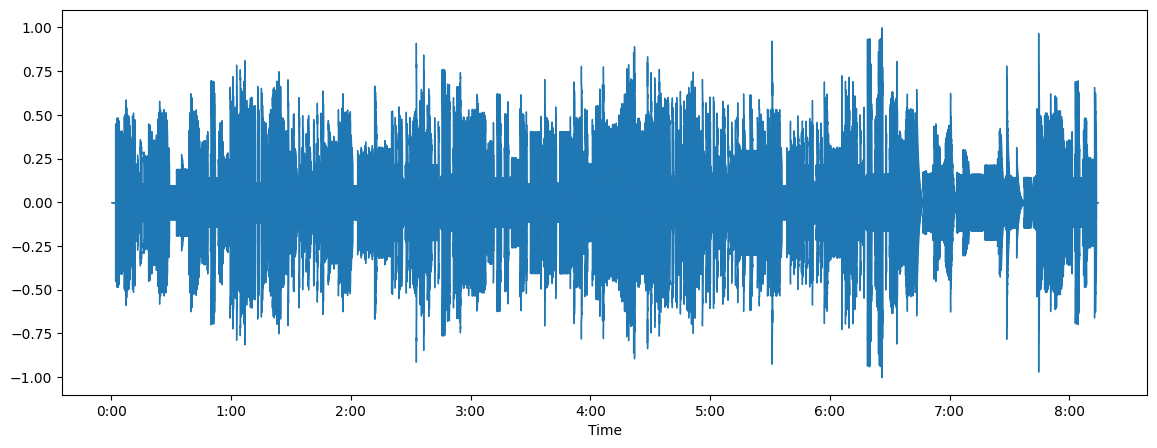

In [ ]:
# Display waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

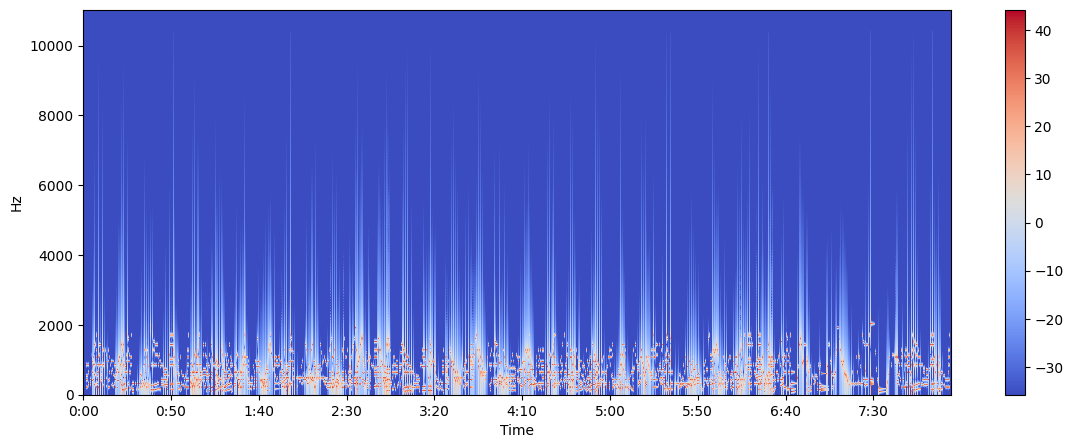

In [ ]:
# Display spectrogram
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

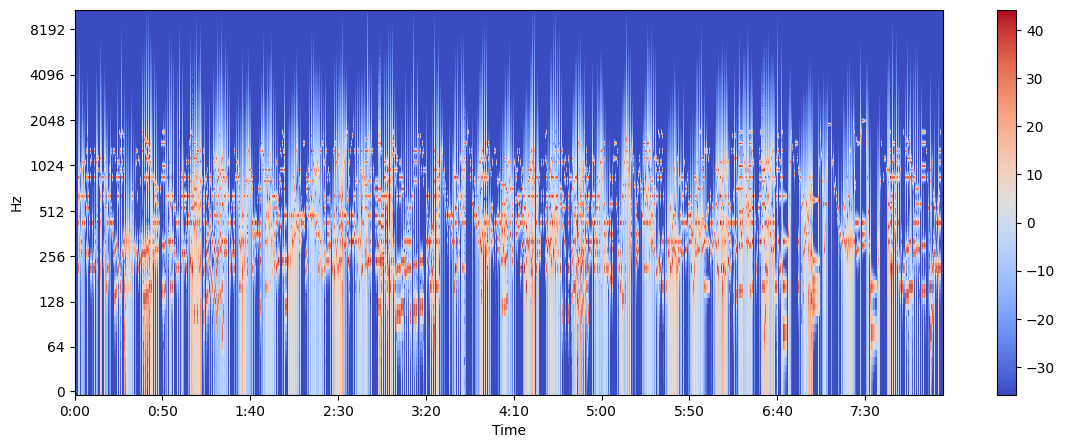

In [ ]:
# Change y-axis to logarithmic form for better visualization
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

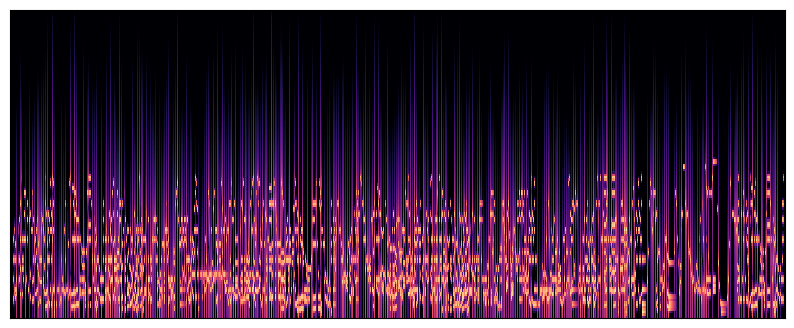

In [ ]:
# Another Spectrogram of MIDI-derived audio
audio_file_path = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/stereo_file1.wav'

def create_spectrogram(audio_file_path):
    y, sr = librosa.load(audio_file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    return spectrogram

# Create a spectrogram
spectrogram = create_spectrogram(audio_file_path)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max))
#plt.colorbar(format='%+2.0f dB')
#plt.title('Spectrogram of MIDI-derived Audio')
plt.savefig('/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/test.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

# Convert MIDI to .WAV and spectrogram

In [ ]:
def midi_to_audio(midi_file_path, output_audio_path, sr=44100):
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    # Print an empirical estimate of its global tempo
    print(midi_data.estimate_tempo())
    # Compute the relative amount of each semitone across the entire song,
    # a proxy for key
    total_velocity = sum(sum(midi_data.get_chroma()))
    print([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])

    # Shift all notes up by 5 semitones
    for instrument in midi_data.instruments:
      # Don't want to shift drum notes
      if not instrument.is_drum:
        for note in instrument.notes:
          note.pitch += 5

    # Synthesize the resulting MIDI data using sine waves
    audio_data = midi_data.synthesize()
    # Write audio data to .wav format
    sf.write(output_audio_path, audio_data, 48000, 'PCM_24')

def create_spectrogram(audio_file_path):
    y, sr = librosa.load(audio_file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    return spectrogram

def process_midi_files_and_create_spectrograms(df):
    for index, row in df.iterrows():
        midi_file_path = row['File_Path']
        subfolder_name = row['Subfolder_Name']
        file_name = row['File_Name']

        # Convert MIDI to audio
        audio_file_path = f'/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/audio/{subfolder_name}_{file_name[:-4]}.wav'
        midi_to_audio(midi_file_path, audio_file_path)

        # create a spectrogram
        spectrogram = create_spectrogram(audio_file_path)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max))
        plt.savefig(f'/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/spectrograms/{subfolder_name}_{file_name[:-4]}.png',
                    bbox_inches='tight', pad_inches=0.0)
        plt.close()

# Create directories to save audio and spectrograms
audio_directory = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/audio'
spectrogram_directory = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/spectrograms'
os.makedirs(audio_directory, exist_ok=True)
os.makedirs(spectrogram_directory, exist_ok=True)

# Process MIDI files and create spectrograms
process_midi_files_and_create_spectrograms(df)

# Pre-processing

In [ ]:
# import re

# path = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/spectrograms'
# folder = os.scandir(path)

# images = []
# labels = []
# composer = {'bach':1, 'byrd':2, 'chopin':3, 'handel':4, 'hummel':5, 'mendelssohn':6, 'mozart':7, 'schumann':8}

# def get_composer_from_file(filename):
#   return re.match(r'(.+?)_', filename)

# for image in folder:
#   if image.isfile():
#     composer_name = get_composer_from_file(image.name)
#     for name, label in composer.items():
#       if composer_name == name:
#         labels.append(label)
#         img_path = os.path.join(path, image.name)
#         img = image.read
#         images.append(img)
# folder.close()

In [ ]:
# print('Grayscale image', num_pic[0])
# cv2_imshow(images[0])
# print('Resized dimensions:', images[0].shape)
# print('Label:', labels[0])

In [33]:
from PIL import Image
from sklearn.model_selection import train_test_split

# Load and preprocess spectrogram images
image_directory = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/spectrograms'
image_size = (775, 308)  # Resize images to this size

images = []
labels = []

for filename in os.listdir(image_directory):
    if filename.endswith('.png'):
        image_path = os.path.join(image_directory, filename)
        label = filename.split('_')[0]  # Extract label from filename
        labels.append(label)

        image = Image.open(image_path)
        #image = image.resize(image_size)
        image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
        images.append(image)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
labels_encoded = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Convert data to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [34]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

X_train shape: (232, 308, 775, 4)
y_train shape: (232, 8)
X_val shape: (58, 308, 775, 4)
y_val shape: (58, 8)


# Create and train the CNN model

In [35]:
model = tf.keras.Sequential([
    # Convolutional first layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(308, 775, 4)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Make 1-D vector
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    # Output layer
    tf.keras.layers.Dense(8, activation='softmax'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 306, 773, 32)      1184      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 153, 386, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 151, 384, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 192, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 73, 190, 128)      73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 95, 128)     

# Compile and train the model

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/15
4/4 [==============================] - 4s 690ms/step - loss: 8.4278 - accuracy: 0.1940 - val_loss: 3.9525 - val_accuracy: 0.1897
Epoch 2/15
4/4 [==============================] - 2s 488ms/step - loss: 2.9991 - accuracy: 0.1379 - val_loss: 2.1081 - val_accuracy: 0.2241
Epoch 3/15
4/4 [==============================] - 2s 495ms/step - loss: 2.0581 - accuracy: 0.1466 - val_loss: 1.9815 - val_accuracy: 0.1897
Epoch 4/15
4/4 [==============================] - 2s 490ms/step - loss: 1.9654 - accuracy: 0.1940 - val_loss: 1.9652 - val_accuracy: 0.1379
Epoch 5/15
4/4 [==============================] - 2s 485ms/step - loss: 1.9312 - accuracy: 0.2414 - val_loss: 1.9690 - val_accuracy: 0.1379
Epoch 6/15
4/4 [==============================] - 2s 490ms/step - loss: 1.8514 - accuracy: 0.2457 - val_loss: 1.8525 - val_accuracy: 0.3621
Epoch 7/15
4/4 [==============================] - 2s 494ms/step - loss: 1.6914 - accuracy: 0.4784 - val_loss: 1.7965 - val_accuracy: 0.3793
Epoch 8/15
4/4 [====

2/2 [==============================] - 0s 93ms/step - loss: 1.5450 - accuracy: 0.5000
Test accuracy: 0.5


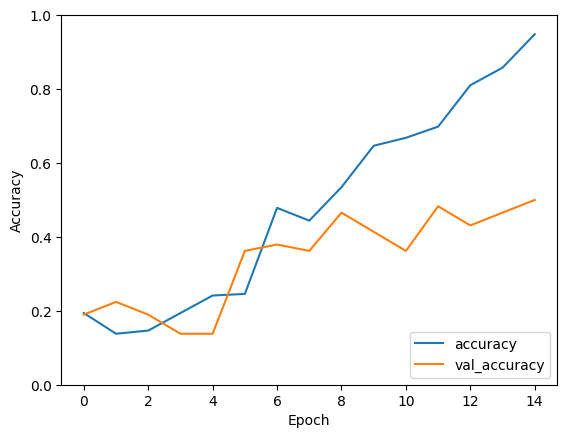

In [37]:
# Plot model accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_val, axis=1) # convert y_val to single-digit, not one-hot-encoded

# Method to easily print required metrics
def print_metrics(y_val, y_pred):
  print("Accuracy: {}".format(accuracy_score(y_val, y_pred)))
  print("Precision: {}".format(precision_score(y_val, y_pred, average='weighted')))
  print("Recall: {}".format(recall_score(y_val, y_pred, average='weighted')))
  print("F1 Score: {}".format(f1_score(y_val, y_pred, average='weighted')))

print_metrics(y_val, y_pred)

2/2 [==============================] - 0s 89ms/step
Accuracy: 0.5
Precision: 0.5138204707170225
Recall: 0.5
F1 Score: 0.4989656441562068


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
